In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVC
from sklearn.cluster import KMeans

import datetime

#from library.sb_utils import save_file

In [2]:
tf_df = pd.read_csv('../data/raw/data/track_features/tf_mini.csv')
tf_df_dummy = pd.get_dummies(tf_df, columns=['key','time_signature','mode'])

In [3]:
from sklearn.preprocessing import StandardScaler

# only pick these columns to do the clustering
sel_col_names = ['acousticness','beat_strength','danceability',
                        'dyn_range_mean', 'energy', 'flatness','instrumentalness', 'liveness', 
                        'loudness', 'mechanism', 'organism','speechiness','valence',
                        'acoustic_vector_0','acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
                        'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6','acoustic_vector_7']
x_cols = tf_df_dummy[sel_col_names]

# rescale the data
scaler = StandardScaler()
x_cols_scaled = scaler.fit_transform(x_cols)

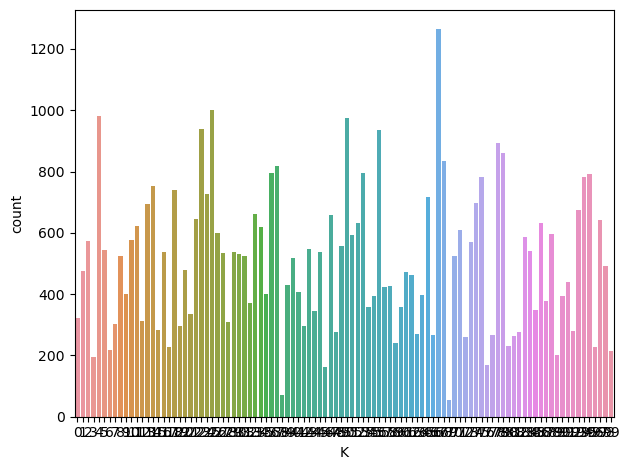

In [4]:
# k = 50 looks ok
km_model = KMeans(n_clusters = 100, random_state=23)
km_model.fit(x_cols_scaled)
clus = pd.DataFrame(km_model.predict(x_cols_scaled))
clus_count = pd.DataFrame(clus.value_counts(), columns = ['count']).reset_index()
clus_count
ax = sns.barplot(x = clus_count.iloc[:,0], y = clus_count['count'])
ax.set(xlabel='K', ylabel='count')
plt.tight_layout()
plt.show()

In [5]:
tf_df_dummy['clus'] = clus
tf_df_dummy['clus'] = 'c' + tf_df_dummy['clus'].astype(str)

In [6]:
log_df = pd.read_csv('../data/raw/data/training_set/log_mini.csv')
log_df_dummy = pd.get_dummies(log_df, columns=['hist_user_behavior_reason_end', 'hist_user_behavior_reason_start', 'context_type'])


In [7]:
df = log_df_dummy.merge(tf_df_dummy, left_on = 'track_id_clean', right_on = 'track_id')
df.sort_values(by = ['session_id', 'session_position'],inplace = True)
df

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,key_10,key_11,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5,mode_major,mode_minor,clus
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,0,0,0,0,0,1,0,1,0,c27
45,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,...,0,0,0,0,0,1,0,0,1,c23
50,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,...,1,0,0,0,0,1,0,1,0,c67
327,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,...,0,0,0,0,0,1,0,1,0,c61
353,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,...,0,0,0,0,0,1,0,1,0,c74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134522,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,16,20,t_360910e8-2a84-42b0-baf1-59abcf96a1f2,False,False,False,True,0,1,...,0,0,0,0,0,1,0,0,1,c19
134516,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,17,20,t_aa2fff77-9b0a-4fa3-a685-ecef50310e8a,False,False,False,True,0,1,...,0,0,0,0,0,1,0,0,1,c19
134510,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,18,20,t_f673e1b7-4ebe-4fc1-ac24-a9f25de70381,False,False,False,True,0,1,...,0,0,0,0,0,1,0,1,0,c31
134504,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,19,20,t_e172e8e7-7161-42a9-acb0-d606346c8f87,False,False,False,True,0,1,...,0,0,0,0,0,1,0,0,1,c37


In [8]:
df.columns

Index(['session_id', 'session_position', 'session_length', 'track_id_clean',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium',
       'hist_user_behavior_reason_end_backbtn',
       'hist_user_behavior_reason_end_clickrow',
       'hist_user_behavior_reason_end_endplay',
       'hist_user_behavior_reason_end_fwdbtn',
       'hist_user_behavior_reason_end_logout',
       'hist_user_behavior_reason_end_remote',
       'hist_user_behavior_reason_end_trackdone',
       'hist_user_behavior_reason_start_appload',
       'hist_user_behavior_reason_start_backbtn',
       'hist_user_behavior_reason_start_clickrow',
       'hist_user_behavior_reason_start_endplay',
       'hist_user_behavior_reason_start_fwdbtn',
       'hist_user_behavior_rea

In [9]:
df.dtypes[0:30]

session_id                                  object
session_position                             int64
session_length                               int64
track_id_clean                              object
skip_1                                        bool
skip_2                                        bool
skip_3                                        bool
not_skipped                                   bool
context_switch                               int64
no_pause_before_play                         int64
short_pause_before_play                      int64
long_pause_before_play                       int64
hist_user_behavior_n_seekfwd                 int64
hist_user_behavior_n_seekback                int64
hist_user_behavior_is_shuffle                 bool
hour_of_day                                  int64
date                                        object
premium                                       bool
hist_user_behavior_reason_end_backbtn        uint8
hist_user_behavior_reason_end_c

In [10]:
bool_col = ['skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_is_shuffle','premium',
       'hist_user_behavior_reason_end_backbtn',
       'hist_user_behavior_reason_end_clickrow',
       'hist_user_behavior_reason_end_endplay',
       'hist_user_behavior_reason_end_fwdbtn',
       'hist_user_behavior_reason_end_logout',
       'hist_user_behavior_reason_end_remote',
       'hist_user_behavior_reason_end_trackdone',
       'hist_user_behavior_reason_start_appload',
       'hist_user_behavior_reason_start_backbtn',
       'hist_user_behavior_reason_start_clickrow',
       'hist_user_behavior_reason_start_endplay',
       'hist_user_behavior_reason_start_fwdbtn',
       'hist_user_behavior_reason_start_playbtn',
       'hist_user_behavior_reason_start_remote',
       'hist_user_behavior_reason_start_trackdone',
       'hist_user_behavior_reason_start_trackerror', 'context_type_catalog',
       'context_type_charts', 'context_type_editorial_playlist',
       'context_type_personalized_playlist', 'context_type_radio',
       'context_type_user_collection', 
       'key_0', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'time_signature_0', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5', 'mode_major', 'mode_minor']

df[bool_col] = df[bool_col].astype('bool')

In [11]:
# does not help
# df.loc[:,df.dtypes=='int64'] = df.loc[:,df.dtypes=='int64'].astype('float')

In [12]:
df.dtypes[0:30]

session_id                                  object
session_position                             int64
session_length                               int64
track_id_clean                              object
skip_1                                        bool
skip_2                                        bool
skip_3                                        bool
not_skipped                                   bool
context_switch                                bool
no_pause_before_play                          bool
short_pause_before_play                       bool
long_pause_before_play                        bool
hist_user_behavior_n_seekfwd                 int64
hist_user_behavior_n_seekback                int64
hist_user_behavior_is_shuffle                 bool
hour_of_day                                  int64
date                                        object
premium                                       bool
hist_user_behavior_reason_end_backbtn         bool
hist_user_behavior_reason_end_c

## Data spliting
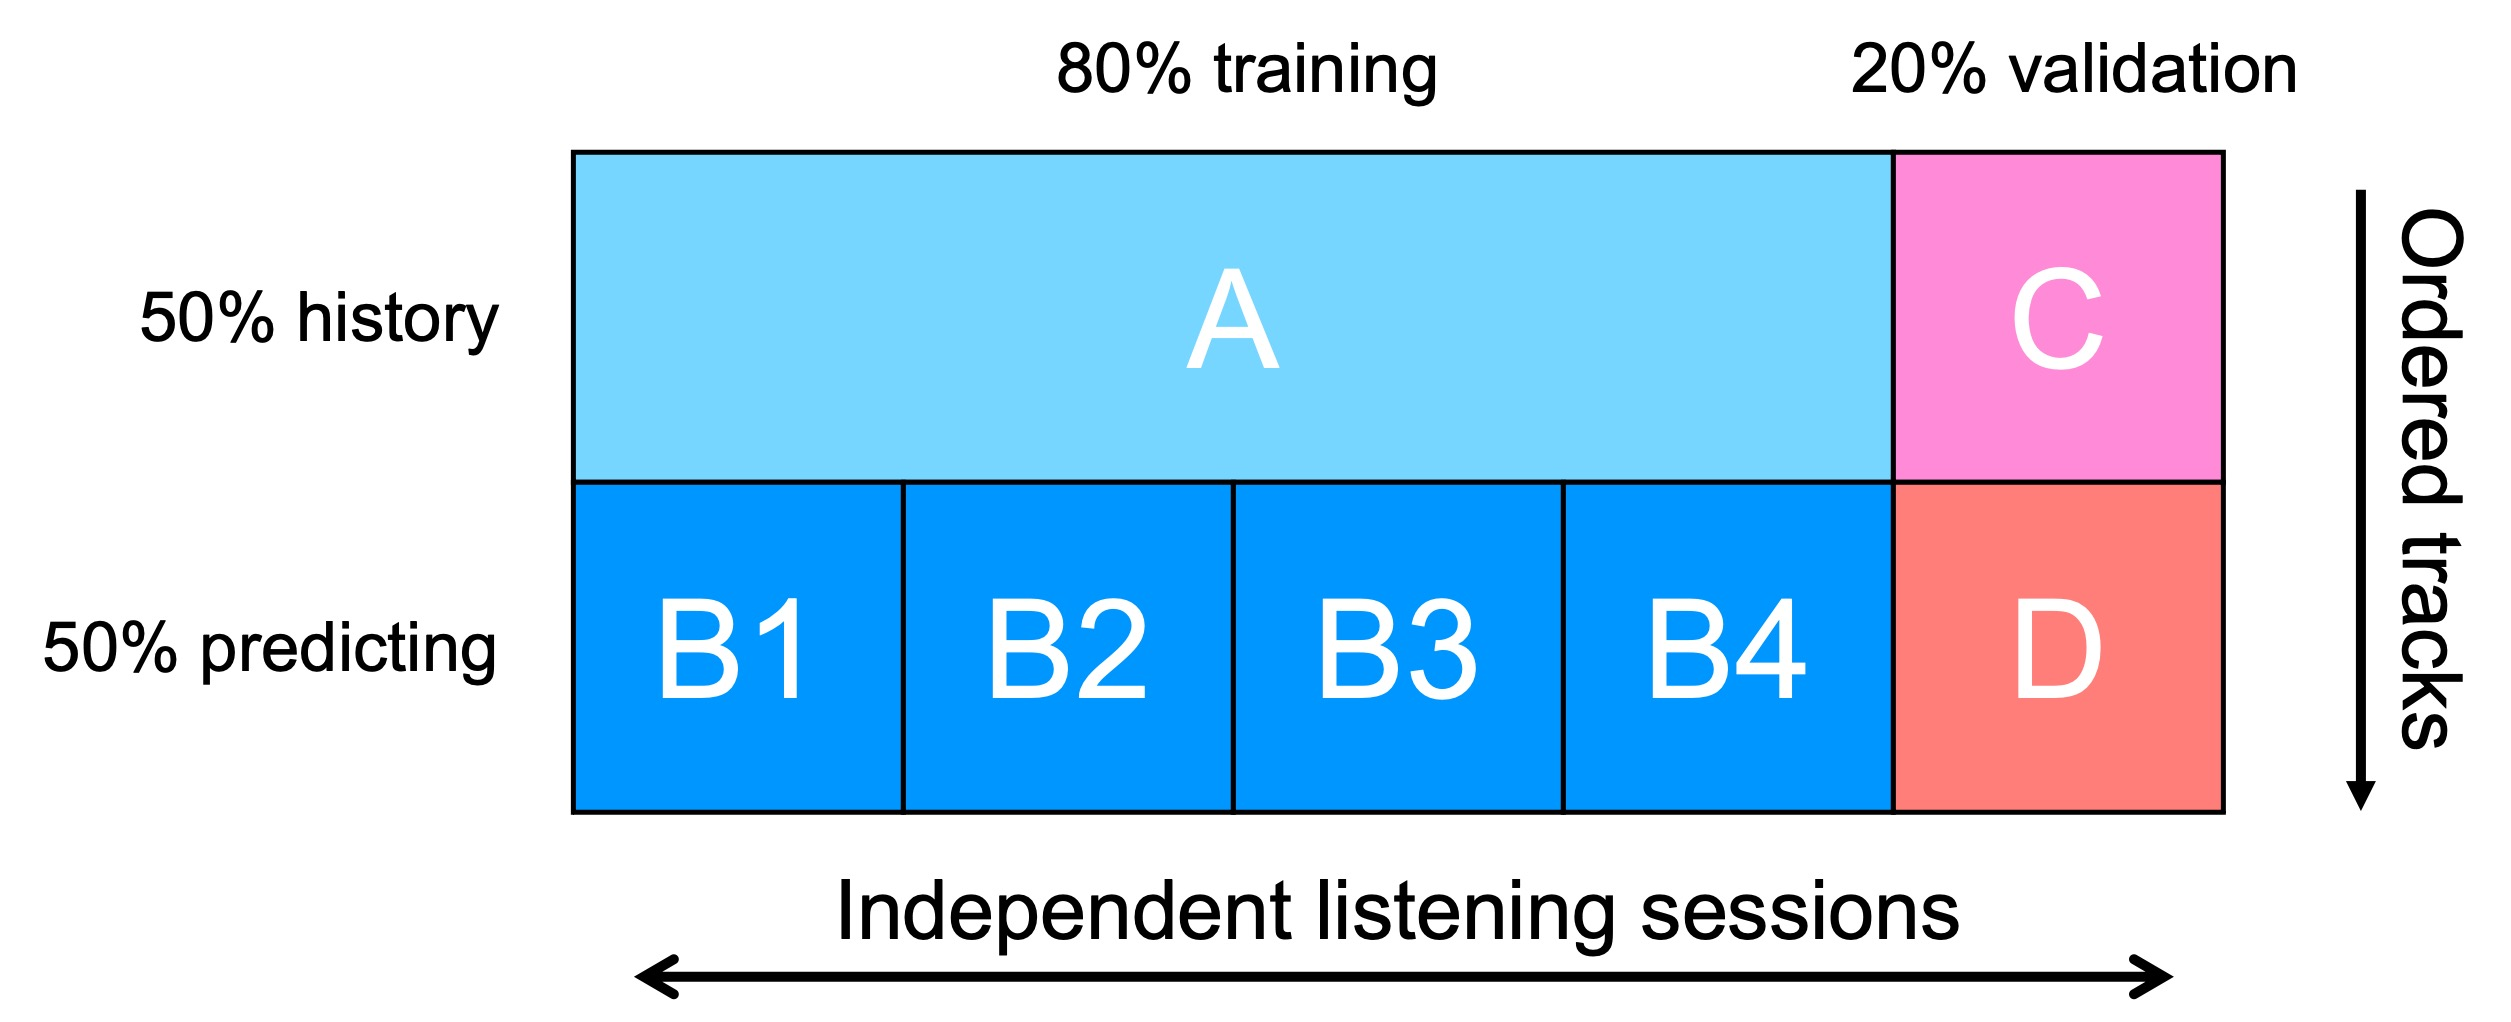


In [13]:
# splitting the data

from sklearn.model_selection import StratifiedKFold, GroupKFold

# splitting the validation and training sessions
train_list = []
test_list = []
gkf = GroupKFold(n_splits=5)
for train, test in gkf.split(df, groups = df['session_id']):
    train_list.append(train)
    test_list.append(test)
    
df_train = df.iloc[train_list[0].tolist()] # training set (A+B)
df_valid = df.iloc[test_list[0].tolist()] # validation set (C+D), untouched



# split the data into history (A) and predicting (B)
skf1 = StratifiedKFold(n_splits=2)
history_list = []
predicting_list = []
for h, p in skf1.split(df_train, df_train['session_id']):
    history_list.append(h)
    predicting_list.append(p)
        
df_history = df_train.iloc[history_list[1].tolist()]
df_predicting = df_train.iloc[predicting_list[1].tolist()]



# split the valid data into history (C) and predicting (D)
skf2 = StratifiedKFold(n_splits=2)
history_list = []
predicting_list = []
for h, p in skf2.split(df_valid, df_valid['session_id']):
    history_list.append(h)
    predicting_list.append(p)
        
df_valid_history = df_valid.iloc[history_list[1].tolist()]
df_valid_predicting = df_valid.iloc[predicting_list[1].tolist()]




# split the predicting set (B) into 4 cross-validation groups
# no need to split history set (A), as it will be used to calculate the similarity matrix
train_pred_list = []
test_pred_list = []
gkf2 = GroupKFold(n_splits=4)
for train, test in gkf2.split(df_predicting, groups = df_predicting['session_id']):
    train_pred_list.append(train)
    test_pred_list.append(test)
    
df_train_pred_set1 = df_predicting.iloc[train_pred_list[0].tolist()] # training_predicting set (B2 + B3 + B4)
df_train_pred_set2 = df_predicting.iloc[train_pred_list[1].tolist()] # training_predicting set (B1 + B3 + B4)
df_train_pred_set3 = df_predicting.iloc[train_pred_list[2].tolist()] # training_predicting set (B1 + B2 + B4)
df_train_pred_set4 = df_predicting.iloc[train_pred_list[3].tolist()] # training_predicting set (B1 + B2 + B3)


df_test_pred_set1 = df_predicting.iloc[test_pred_list[0].tolist()] # testing_predicting set (B1)
df_test_pred_set2 = df_predicting.iloc[test_pred_list[1].tolist()] # testing_predicting set (B2)
df_test_pred_set3 = df_predicting.iloc[test_pred_list[2].tolist()] # testing_predicting set (B3)
df_test_pred_set4 = df_predicting.iloc[test_pred_list[3].tolist()] # testing_predicting set (B4)

df_history_valid = pd.concat([df_train, df_valid_history])

In [18]:
def cal_similarMat(df_train):
    import numpy as np
    import pandas as pd
    
    
    sessions = list(np.sort(df_train['session_id'].unique())) 
    tracks = list(df_train['clus'].unique()) 
    no_skip_2 = (list(df_train['skip_2']==False))*1 # use *1 to convert bool to integer
    
    DfSessionUnique = []
    DfSessionUnique = pd.DataFrame(sessions,columns=['sessions'])
    
    from scipy import sparse
    from pandas.api.types import CategoricalDtype

    rows = df_train['session_id'].astype(CategoricalDtype(categories=sessions)).cat.codes # unique sessions (index)

    # Get the associated row indices
    cols = df_train['clus'].astype(CategoricalDtype(categories=tracks)).cat.codes # unique tracks (column)
    
    
    # Get the associated column indices
    #Compressed Sparse Row matrix
    listeningSparse = []
    listeningSparse = sparse.csr_matrix((no_skip_2, (rows, cols)), shape=(len(sessions), len(tracks)))
    #csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
    #where data, row_ind and col_ind satisfy the relationship a[row_ind[k], col_ind[k]] = data[k]. , see https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

    listeningSparse
    #a sparse matrix is not a pandas dataframe, but sparse matrices are efficient for row slicing and fast matrix vector products
    
    
    DataBinary = df_train.copy()
    DataBinary['ListenYes'] = (DataBinary['skip_2'] == False)*1
    
    data2=DataBinary[['session_id','clus','ListenYes']]

    data2['ListenYes'].replace(0, -1, inplace = True)

    data3 = data2.groupby(['session_id', 'clus']).agg({'ListenYes':['sum']})
    data3 = data3.reset_index()
    data3.columns = data3.columns.droplevel(level = 1) # take out the unwanted level
    
    
    DfMatrix = pd.pivot_table(data3, values='ListenYes', index='session_id', columns='clus')

    DfMatrix=DfMatrix.fillna(0) #NaN values need to get replaced by 0, meaning they have not been listened yet.
    
    DfResetted = DfMatrix.reset_index().rename_axis(None, axis=1) 

    DfTracksListen = DfResetted.drop(columns=['session_id'])

    #Normalization
    import numpy as np
    DfTracksListenNorm = DfTracksListen / np.sqrt(np.square(DfTracksListen).sum(axis=0)) 

    #### similarity and correlation
    # Calculating with Vectors to compute Cosine Similarities
    TrackTrackSim = DfTracksListenNorm.transpose().dot(DfTracksListenNorm) 

    #Another approach to the above would be using correlation
    TrackTrackCorr = DfTracksListenNorm.corr()
    
    #Spearman correlation
    TrackTrackSpearCorr = DfTracksListenNorm.corr(method = 'spearman')
    
    #Kendall correlation
    TrackTrackKendCorr = DfTracksListenNorm.corr(method = 'kendall')
    
    from scipy.spatial.distance import cdist
    
    #### distances
    # Euclidean distance
    TrackTrackEuclDist = pd.DataFrame(cdist(DfTracksListenNorm.T,DfTracksListenNorm.T, 'euclidean'), index = TrackTrackSim.index, columns = TrackTrackSim.columns)

    # Squared Euclidean distance
    TrackTrackSqEuclDist = pd.DataFrame(cdist(DfTracksListenNorm.T,DfTracksListenNorm.T, 'sqeuclidean'), index = TrackTrackSim.index, columns = TrackTrackSim.columns)
    
    # Manhattan distance
    TrackTrackManhDist = pd.DataFrame(cdist(DfTracksListenNorm.T,DfTracksListenNorm.T, 'cityblock'), index = TrackTrackSim.index, columns = TrackTrackSim.columns)

    # Canberra distance
    TrackTrackCanbDist = pd.DataFrame(cdist(DfTracksListenNorm.T,DfTracksListenNorm.T, 'canberra'), index = TrackTrackSim.index, columns = TrackTrackSim.columns)

    #### boolean distances
    # Hamming distance
    TrackTrackHammDist = pd.DataFrame(cdist(DfTracksListenNorm.T>0,DfTracksListenNorm.T>0, 'hamming'), index = TrackTrackSim.index, columns = TrackTrackSim.columns)

 

    # Create a place holder matrix for similarities, and fill in the session column
    SessTrackSimilarity = pd.DataFrame(index=DfResetted.index, columns=DfResetted.columns)
    SessTrackSimilarity.iloc[:,:1] = DfResetted.iloc[:,:1]
    SessTrackCorrelation = SessTrackSimilarity.copy()
    SessTrackSpearCorr = SessTrackSimilarity.copy()
    SessTrackKendCorr = SessTrackSimilarity.copy()
    SessTrackEuclDist = SessTrackSimilarity.copy()
    SessTrackSqEuclDist = SessTrackSimilarity.copy()
    SessTrackManhDist = SessTrackSimilarity.copy()
    SessTrackCanbDist = SessTrackSimilarity.copy()
    SessTrackHammDist = SessTrackSimilarity.copy()

    #We now loop through the rows and columns filling in empty spaces with similarity scores.
    
    SessionListening = []
    TrackTopSimilarity = []

    for i in range(0,len(SessTrackSimilarity.index)):
        for j in range(1,len(SessTrackSimilarity.columns)):

            ses = SessTrackSimilarity.index[i]
            tra = SessTrackSimilarity.columns[j]

            SessionListening = DfTracksListen.loc[ses,]
            TrackSimilarity = TrackTrackSim[tra]
            TrackCorrelation = TrackTrackCorr[tra]
            TrackSpearCorr = TrackTrackSpearCorr[tra]
            TrackKendCorr = TrackTrackKendCorr[tra]
            TrackEuclDist = TrackTrackEuclDist[tra]
            TrackSqEuclDist = TrackTrackSqEuclDist[tra]
            TrackManhDist = TrackTrackManhDist[tra]
            TrackCanbDist = TrackTrackCanbDist[tra]
            TrackHammDist = TrackTrackHammDist[tra]

            SessTrackSimilarity.loc[i][j] = sum(SessionListening*TrackSimilarity)/sum(TrackSimilarity)
            SessTrackCorrelation.loc[i][j] = sum(SessionListening*TrackCorrelation)/sum(TrackCorrelation)
            SessTrackSpearCorr.loc[i][j] = sum(SessionListening*TrackSpearCorr)/sum(TrackSpearCorr)
            SessTrackKendCorr.loc[i][j] = sum(SessionListening*TrackKendCorr)/sum(TrackKendCorr)
            SessTrackEuclDist.loc[i][j] = sum(SessionListening*TrackEuclDist)/sum(TrackEuclDist)
            SessTrackSqEuclDist.loc[i][j] = sum(SessionListening*TrackSqEuclDist)/sum(TrackSqEuclDist)
            SessTrackManhDist.loc[i][j] = sum(SessionListening*TrackManhDist)/sum(TrackManhDist)
            SessTrackCanbDist.loc[i][j] = sum(SessionListening*TrackCanbDist)/sum(TrackCanbDist)
            SessTrackHammDist.loc[i][j] = sum(SessionListening*TrackHammDist)/sum(TrackHammDist)

    
    SessTrackSimilarity.set_index('session_id', inplace = True)
    SessTrackCorrelation.set_index('session_id', inplace = True)
    SessTrackSpearCorr.set_index('session_id', inplace = True)
    SessTrackKendCorr.set_index('session_id', inplace = True)
    SessTrackEuclDist.set_index('session_id', inplace = True)
    SessTrackSqEuclDist.set_index('session_id', inplace = True)
    SessTrackManhDist.set_index('session_id', inplace = True)
    SessTrackCanbDist.set_index('session_id', inplace = True)
    SessTrackHammDist.set_index('session_id', inplace = True)
    
    
    sim_output = [SessTrackSimilarity, SessTrackCorrelation, SessTrackSpearCorr, SessTrackKendCorr, SessTrackEuclDist, SessTrackSqEuclDist, SessTrackManhDist, SessTrackCanbDist, SessTrackHammDist]
    
    
    return sim_output


In [20]:
cal_List = [pd.concat([df_history,df_train_pred_set1]),
           pd.concat([df_history,df_train_pred_set2]),
           pd.concat([df_history,df_train_pred_set3]),
           pd.concat([df_history,df_train_pred_set4]),
           df_history_valid]

from timeit import default_timer as timer #to see how long the computation will take
start = timer()

from joblib import Parallel, delayed
sim_output_List = Parallel(n_jobs=8, verbose=1)(delayed(cal_similarMat)(df) for df in cal_List)

end = timer()
print('\nRuntime: %0.2fs' % (end - start))


Runtime: 2325.11s


/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_26463/964399820.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Runtime: 2346.93s


/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_26463/964399820.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Runtime: 2364.18s


/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_26463/964399820.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Runtime: 2367.98s


/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_26463/964399820.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
sim_output_set1 = sim_output_List[0]
sim_output_set2 = sim_output_List[1]
sim_output_set3 = sim_output_List[2]
sim_output_set4 = sim_output_List[3]
sim_output_valid = sim_output_List[4]

In [33]:
def SimLookup(sim_output, df_test_pred):
    df_test_pred['cos_score']=sim_output[0].lookup(df_test_pred['session_id'],df_test_pred['clus'])
    df_test_pred['corr_score']=sim_output[1].lookup(df_test_pred['session_id'],df_test_pred['clus'])
    df_test_pred['SpearCorr_score']=sim_output[2].lookup(df_test_pred['session_id'],df_test_pred['clus'])
    df_test_pred['KendCorr_score']=sim_output[3].lookup(df_test_pred['session_id'],df_test_pred['clus'])
    df_test_pred['EuclDist']=sim_output[4].lookup(df_test_pred['session_id'],df_test_pred['clus'])
    df_test_pred['SqEuclDist']=sim_output[5].lookup(df_test_pred['session_id'],df_test_pred['clus'])
    df_test_pred['ManhDist']=sim_output[6].lookup(df_test_pred['session_id'],df_test_pred['clus'])
    df_test_pred['CanbDist']=sim_output[7].lookup(df_test_pred['session_id'],df_test_pred['clus'])
    df_test_pred['HammDist']=sim_output[8].lookup(df_test_pred['session_id'],df_test_pred['clus'])
        
    return df_test_pred
    


In [34]:
import warnings
warnings.simplefilter("ignore")

df_test_pred_set1 = SimLookup(sim_output_set1, df_test_pred_set1)
df_test_pred_set2 = SimLookup(sim_output_set2, df_test_pred_set2)
df_test_pred_set3 = SimLookup(sim_output_set3, df_test_pred_set3)
df_test_pred_set4 = SimLookup(sim_output_set4, df_test_pred_set4)



In [63]:
def featureAugment(df_history, cols):
    df_fa = pd.DataFrame()
    
    # split the data based on skip_2
    df_history_T = df_history.loc[df_history['skip_2']==True]
    df_history_F = df_history.loc[df_history['skip_2']==False]
        
    for c in cols:
        df_fa[c+'_mean'] = df_history.groupby(['session_id'])[c].mean()
        df_fa[c+'_std'] = df_history.groupby(['session_id'])[c].std()
        df_fa[c+'_skew'] = df_history.groupby(['session_id'])[c].skew()
        df_fa[c+'_median'] = df_history.groupby(['session_id'])[c].median()
        
        df_fa[c+'_T_mean'] = df_history_T.groupby(['session_id'])[c].mean()
        df_fa[c+'_T_std'] = df_history_T.groupby(['session_id'])[c].std()
        df_fa[c+'_T_skew'] = df_history_T.groupby(['session_id'])[c].skew()
        df_fa[c+'_T_median'] = df_history_T.groupby(['session_id'])[c].median()
        
        df_fa[c+'_F_mean'] = df_history_F.groupby(['session_id'])[c].mean()
        df_fa[c+'_F_std'] = df_history_F.groupby(['session_id'])[c].std()
        df_fa[c+'_F_skew'] = df_history_F.groupby(['session_id'])[c].skew()
        df_fa[c+'_F_median'] = df_history_F.groupby(['session_id'])[c].median()
        
        if df_history[c].dtypes.name != 'bool':
            df_fa[c+'_max'] = df_history.groupby(['session_id'])[c].max()
            df_fa[c+'_min'] = df_history.groupby(['session_id'])[c].min()
            df_fa[c+'_range'] = np.subtract(df_fa[c+'_max'], df_fa[c+'_min'], dtype=np.float32)
            df_fa[c+'_q25'] = df_history.groupby(['session_id'])[c].quantile(.25)
            df_fa[c+'_q75'] = df_history.groupby(['session_id'])[c].quantile(.75)
            df_fa[c+'_iqr'] = np.subtract(df_fa[c+'_q75'], df_fa[c+'_q25'], dtype=np.float32)
            
            df_fa[c+'_T_max'] = df_history_T.groupby(['session_id'])[c].max()
            df_fa[c+'_T_min'] = df_history_T.groupby(['session_id'])[c].min()
            df_fa[c+'_T_range'] = np.subtract(df_fa[c+'_T_max'], df_fa[c+'_T_min'], dtype=np.float32)
            df_fa[c+'_T_q25'] = df_history_T.groupby(['session_id'])[c].quantile(.25)
            df_fa[c+'_T_q75'] = df_history_T.groupby(['session_id'])[c].quantile(.75)
            df_fa[c+'_T_iqr'] = np.subtract(df_fa[c+'_T_q75'], df_fa[c+'_T_q25'], dtype=np.float32)
            
            df_fa[c+'_F_max'] = df_history_F.groupby(['session_id'])[c].max()
            df_fa[c+'_F_min'] = df_history_F.groupby(['session_id'])[c].min()
            df_fa[c+'_F_range'] = np.subtract(df_fa[c+'_F_max'], df_fa[c+'_F_min'], dtype=np.float32)
            df_fa[c+'_F_q25'] = df_history_F.groupby(['session_id'])[c].quantile(.25)
            df_fa[c+'_F_q75'] = df_history_F.groupby(['session_id'])[c].quantile(.75)
            df_fa[c+'_F_iqr'] = np.subtract(df_fa[c+'_F_q75'], df_fa[c+'_F_q25'], dtype=np.float32)
            
#             df_fa[c+'_mode'] = df_history.groupby(['session_id'])[c].agg(pd.Series.mode)
#             df_fa[c+'_PearsonTrend'] = df_history.groupby(['session_id'])[c, 'session_position'].corr().iloc[0::2,-1]
#             df_fa[c+'_SpearTrend'] = df_history.groupby(['session_id'])[c, 'session_position'].corr('spearman').iloc[0::2,-1]
#             df_fa[c+'_KendallTrend'] = df_history.groupby(['session_id'])[c, 'session_position'].corr('kendall').iloc[0::2,-1]

    return df_fa

In [64]:
import warnings
warnings.simplefilter("ignore")

col_FA = ['session_position', 'session_length', 
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'premium',
       'hist_user_behavior_reason_end_backbtn',
       'hist_user_behavior_reason_end_clickrow',
       'hist_user_behavior_reason_end_endplay',
       'hist_user_behavior_reason_end_fwdbtn',
       'hist_user_behavior_reason_end_logout',
       'hist_user_behavior_reason_end_remote',
       'hist_user_behavior_reason_end_trackdone',
       'hist_user_behavior_reason_start_appload',
       'hist_user_behavior_reason_start_backbtn',
       'hist_user_behavior_reason_start_clickrow',
       'hist_user_behavior_reason_start_endplay',
       'hist_user_behavior_reason_start_fwdbtn',
       'hist_user_behavior_reason_start_playbtn',
       'hist_user_behavior_reason_start_remote',
       'hist_user_behavior_reason_start_trackdone',
       'hist_user_behavior_reason_start_trackerror', 'context_type_catalog',
       'context_type_charts', 'context_type_editorial_playlist',
       'context_type_personalized_playlist', 'context_type_radio',
       'context_type_user_collection', 'duration', 'release_year',
       'us_popularity_estimate', 'acousticness', 'beat_strength', 'bounciness',
       'danceability', 'dyn_range_mean', 'energy', 'flatness',
       'instrumentalness', 'liveness', 'loudness', 'mechanism', 'organism',
       'speechiness', 'tempo', 'valence', 'acoustic_vector_0',
       'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
       'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6',
       'acoustic_vector_7', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'time_signature_0', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5', 'mode_major', 'mode_minor']

df_fa = featureAugment(df_history, col_FA)

df_test_pred_set1_FA = df_test_pred_set1.merge(df_fa, left_on = 'session_id', right_on = 'session_id')
df_test_pred_set2_FA = df_test_pred_set2.merge(df_fa, left_on = 'session_id', right_on = 'session_id')
df_test_pred_set3_FA = df_test_pred_set3.merge(df_fa, left_on = 'session_id', right_on = 'session_id')
df_test_pred_set4_FA = df_test_pred_set4.merge(df_fa, left_on = 'session_id', right_on = 'session_id')


In [65]:
df_test_pred_set1_FA.columns[200:300]

Index(['not_skipped_F_mean', 'not_skipped_F_std', 'not_skipped_F_skew',
       'not_skipped_F_median', 'context_switch_mean', 'context_switch_std',
       'context_switch_skew', 'context_switch_median', 'context_switch_T_mean',
       'context_switch_T_std', 'context_switch_T_skew',
       'context_switch_T_median', 'context_switch_F_mean',
       'context_switch_F_std', 'context_switch_F_skew',
       'context_switch_F_median', 'no_pause_before_play_mean',
       'no_pause_before_play_std', 'no_pause_before_play_skew',
       'no_pause_before_play_median', 'no_pause_before_play_T_mean',
       'no_pause_before_play_T_std', 'no_pause_before_play_T_skew',
       'no_pause_before_play_T_median', 'no_pause_before_play_F_mean',
       'no_pause_before_play_F_std', 'no_pause_before_play_F_skew',
       'no_pause_before_play_F_median', 'short_pause_before_play_mean',
       'short_pause_before_play_std', 'short_pause_before_play_skew',
       'short_pause_before_play_median', 'short_pause_be

In [66]:
drop_cols = ['session_id','skip_1', 'skip_2', 'skip_3', 'not_skipped', 'track_id_clean','context_switch','date',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hist_user_behavior_reason_end_backbtn',
       'hist_user_behavior_reason_end_clickrow',
       'hist_user_behavior_reason_end_endplay',
       'hist_user_behavior_reason_end_fwdbtn',
       'hist_user_behavior_reason_end_logout',
       'hist_user_behavior_reason_end_remote',
       'hist_user_behavior_reason_end_trackdone',
       'hist_user_behavior_reason_start_appload',
       'hist_user_behavior_reason_start_backbtn',
       'hist_user_behavior_reason_start_clickrow',
       'hist_user_behavior_reason_start_endplay',
       'hist_user_behavior_reason_start_fwdbtn',
       'hist_user_behavior_reason_start_playbtn',
       'hist_user_behavior_reason_start_remote',
       'hist_user_behavior_reason_start_trackdone',
       'hist_user_behavior_reason_start_trackerror', 'context_type_catalog',
       'context_type_charts', 'context_type_editorial_playlist',
       'context_type_personalized_playlist', 'context_type_radio',
       'context_type_user_collection','track_id','clus']

In [67]:
df_test_pred_set1_FA.drop(columns = drop_cols).columns[0:100]

Index(['session_position', 'session_length', 'hour_of_day', 'premium',
       'duration', 'release_year', 'us_popularity_estimate', 'acousticness',
       'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
       'energy', 'flatness', 'instrumentalness', 'liveness', 'loudness',
       'mechanism', 'organism', 'speechiness', 'tempo', 'valence',
       'acoustic_vector_0', 'acoustic_vector_1', 'acoustic_vector_2',
       'acoustic_vector_3', 'acoustic_vector_4', 'acoustic_vector_5',
       'acoustic_vector_6', 'acoustic_vector_7', 'key_0', 'key_1', 'key_2',
       'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'time_signature_0', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5', 'mode_major', 'mode_minor',
       'cos_score', 'corr_score', 'SpearCorr_score', 'KendCorr_score',
       'EuclDist', 'SqEuclDist', 'ManhDist', 'CanbDist', 'HammDist',
       'session_position_mean', 'session_position_st

In [68]:
# check whether there's any columns have NaN
df_test_pred_set1_FA.loc[:,df_test_pred_set1_FA.isna().sum()>0].columns

Index(['session_position_T_mean', 'session_position_T_std',
       'session_position_T_skew', 'session_position_T_median',
       'session_position_F_mean', 'session_position_F_std',
       'session_position_F_skew', 'session_position_F_median',
       'session_position_T_max', 'session_position_T_min',
       ...
       'mode_major_F_skew', 'mode_major_F_median', 'mode_minor_T_mean',
       'mode_minor_T_std', 'mode_minor_T_skew', 'mode_minor_T_median',
       'mode_minor_F_mean', 'mode_minor_F_std', 'mode_minor_F_skew',
       'mode_minor_F_median'],
      dtype='object', length=1028)

In [69]:
df_test_pred_set1_FA.shape

(16788, 1638)

In [70]:
df_test_pred_set1_FA.isna().sum().sort_values(ascending = False)[0:50]

context_type_charts_F_skew                         5204
key_2_F_skew                                       5204
hist_user_behavior_reason_end_clickrow_F_skew      5204
energy_F_skew                                      5204
acoustic_vector_7_F_skew                           5204
hist_user_behavior_reason_end_endplay_F_skew       5204
hist_user_behavior_reason_end_fwdbtn_F_skew        5204
dyn_range_mean_F_skew                              5204
key_0_F_skew                                       5204
hist_user_behavior_reason_end_logout_F_skew        5204
key_1_F_skew                                       5204
danceability_F_skew                                5204
context_switch_F_skew                              5204
hist_user_behavior_reason_end_remote_F_skew        5204
hist_user_behavior_reason_end_trackdone_F_skew     5204
session_length_F_skew                              5204
bounciness_F_skew                                  5204
key_3_F_skew                                    

In [71]:
## evaludation functions

def get_ground_truth(test_output):

    ground_truths = [] 
    df = test_output.copy()
    df[['session_position','session_length']] = df[['session_position','session_length']].astype('int64')
    df = df[['session_id','skip_2','session_position','session_length']].loc[df['session_position']*2 > df['session_length']]
    df = df.reset_index()
    current_index = 0
    while current_index < len(df):
        partial_length = df['session_length'].iloc[current_index]-df['session_position'].iloc[current_index]+1
        session_skips = list(df.loc[current_index:current_index+partial_length-1, 'skip_2'])
        ground_truths.append(session_skips)
        current_index += partial_length 
        
    return ground_truths


def get_submission(test_output):
    submission = []
    for s in test_output['session_id'].unique():
        submission.append(np.array(test_output['pred'][test_output['session_id']==s]*1))
        
    return submission


def evaluate(submission,groundtruth):
    ap_sum = 0.0
    first_pred_acc_sum = 0.0
    counter = 0
    for sub, tru in zip(submission, groundtruth):
        if len(sub) != len(tru):
            raise Exception('Line {} should contain {} predictions, but instead contains '
                            '{}'.format(counter+1,len(tru),len(sub)))
        ap_sum += ave_pre(sub,tru,counter)
        first_pred_acc_sum += sub[0] == tru[0]
        counter+=1
    ap = ap_sum/counter
    first_pred_acc = first_pred_acc_sum/counter
    return ap,first_pred_acc


def ave_pre(submission,groundtruth,counter):
    s = 0.0
    t = 0.0
    c = 1.0
    for x, y in zip(submission, groundtruth):
        if x != 0 and x != 1:
            raise Exception('Invalid prediction in line {}, should be 0 or 1'.format(counter))
        if x==y:
            s += 1.0
            t += s / c
        c += 1
    return t/len(groundtruth)

In [ ]:
df_test_pred_setAll_FA = pd.concat([df_test_pred_set1_FA,df_test_pred_set2_FA,df_test_pred_set3_FA,df_test_pred_set4_FA])

gkf2 = GroupKFold(n_splits=4)

RF_pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='median'),
    RandomForestClassifier(random_state=23)
                       )
# RF_pipe.get_params().keys() # check the parameters of the pipeline

params={
    'randomforestclassifier__max_depth':np.arange(2,100,2),
    'randomforestclassifier__n_estimators':[10,50,100,500,1000]}
#setting up the grid search
gs=GridSearchCV(RF_pipe,
                params,
                n_jobs=6,
                cv=gkf2.split(df_test_pred_setAll_FA, groups = df_test_pred_setAll_FA['session_id']))
#fitting gs to training data
gs.fit(df_test_pred_setAll_FA.drop(columns = drop_cols),df_test_pred_setAll_FA['skip_2'])



In [ ]:
pd.DataFrame(gs.cv_results_)

In [ ]:
gs.best_params_

In [87]:
def run_RF(test_set, train_set, drop_cols):

    X_train = pd.concat(train_set).drop(columns = drop_cols)
    X_test = test_set.drop(columns = drop_cols)
    y_train = pd.concat(train_set)['skip_2']
    y_test = test_set['skip_2']
    
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    X_train2 = imp_median.fit_transform(X_train)
    X_test2 = imp_median.fit_transform(X_test)
    
    test_output = test_set.copy()


    rf = RandomForestClassifier(random_state=23, n_jobs = -1, max_depth=5, n_estimators = 500)
    rf.fit(X_train2,y_train)
    score_train = rf.score(X_train2,y_train)
    score_test = rf.score(X_test2,y_test)
    test_output['pred'] = rf.predict(X_test2)
    print('score_train',score_train)
    print('score_test',score_test)


    
    # official evaluation  metrices
    ground_truths = get_ground_truth(test_output)
    submission = get_submission(test_output)
    
    ap,first_pred_acc = evaluate(submission,ground_truths)
    
    print('average precision: {}'.format(ap))
    print('first prediction accuracy: {}'.format(first_pred_acc))
    
    
    
    
    importances = pd.DataFrame({'FEATURE':X_train.columns,'IMPORTANCE':np.round(rf.feature_importances_,3)})
    importances = importances.sort_values('IMPORTANCE',ascending=False).set_index('FEATURE')

    fig, ax = plt.subplots(figsize=(10,5)) 
    sel_range = 30
    sns.barplot(y = importances[0:sel_range].index, x = importances['IMPORTANCE'][0:sel_range], orient = 'h', ax = ax)

    plt.tight_layout()
    plt.show()

score_train 0.656361686919228
score_test 0.6512985465808911
average precision: 0.546396444397203
first prediction accuracy: 0.6895


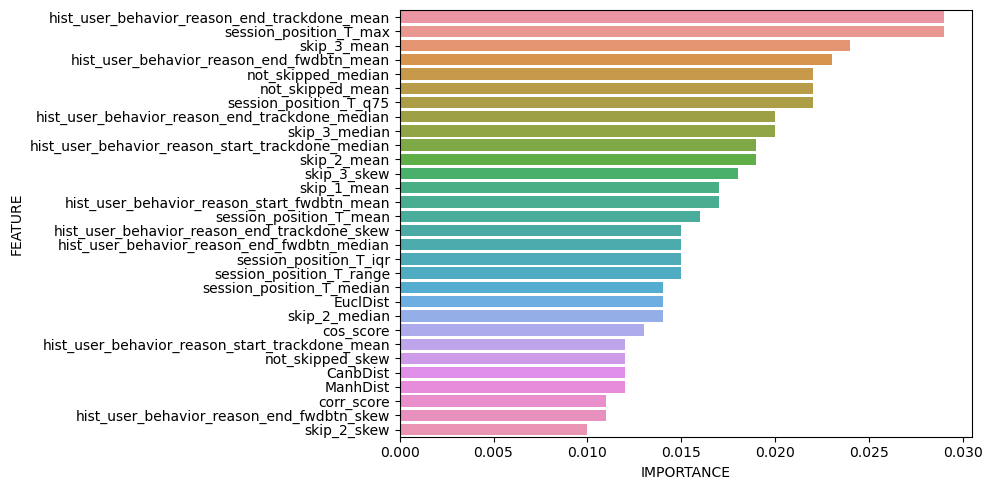

In [88]:
run_RF(df_test_pred_set1_FA, [df_test_pred_set2_FA,df_test_pred_set3_FA,df_test_pred_set4_FA], drop_cols)

score_train 0.6593201493130013
score_test 0.6331903740767215
average precision: 0.5211074551209365
first prediction accuracy: 0.6555


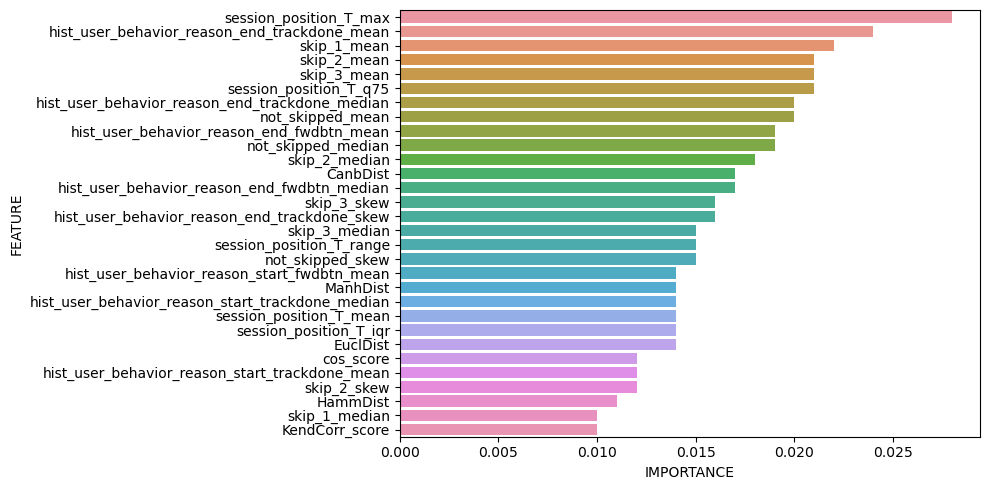

In [89]:
run_RF(df_test_pred_set2_FA, [df_test_pred_set1_FA,df_test_pred_set3_FA,df_test_pred_set4_FA], drop_cols)

score_train 0.6563815423715352
score_test 0.6477245651655945
average precision: 0.5409467253243884
first prediction accuracy: 0.6965


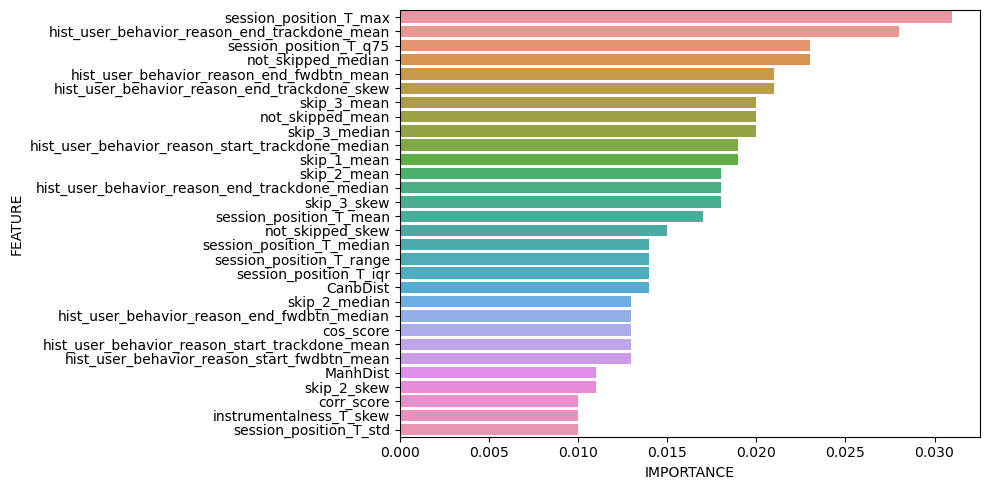

In [90]:
run_RF(df_test_pred_set3_FA, [df_test_pred_set2_FA,df_test_pred_set1_FA,df_test_pred_set4_FA], drop_cols)

score_train 0.6585854975776348
score_test 0.6250893495353824
average precision: 0.5194420688460563
first prediction accuracy: 0.6855


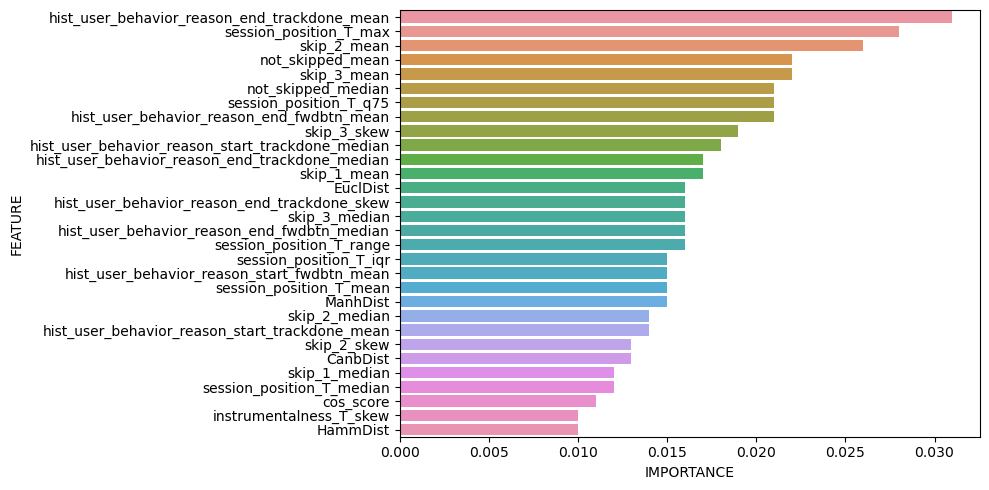

In [91]:
run_RF(df_test_pred_set4_FA, [df_test_pred_set2_FA,df_test_pred_set3_FA,df_test_pred_set1_FA], drop_cols)